In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

# Load Dataset

In [2]:
offers = pd.read_csv("raw_data\offers.csv")
offers.sort_values(by="offer_type")

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"['web', 'email', 'mobile']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']"


In [3]:
events = pd.read_csv("raw_data\events.csv")
events.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
customers = pd.read_csv("raw_data\customers.csv")
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,118,NaN


In [5]:
customers["became_member_on"] = customers["became_member_on"].astype(str)
customers["became_member_on"] = pd.to_datetime(
    customers["became_member_on"], format="%Y%m%d"
)
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


In [6]:
# dataframe of the the blank gender and income and 118 years old. These are removed because of missing values
df_empty = customers[
    (customers["gender"].isna())
    & (customers["income"].isna())
    & (customers["age"] == 118)
]

df_empty.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,118,NaN
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,118,NaN


# Analyzing Events

In [7]:
#dataframe with customers with full details
other_customers = customers[~customers["customer_id"].isin(df_empty["customer_id"].values)]
other_customers.shape

(14825, 5)

In [8]:
#events of customers with full details
other_events = events[~events["customer_id"].isin(df_empty["customer_id"].values)]
other_events.shape

(272762, 4)

In [9]:
# event stages which are in the dataset
other_events["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [10]:
# Event Types dataframes
transactions = other_events[other_events["event"] == "transaction"].copy()
offers_received = other_events[other_events["event"] == "offer received"].copy()
offers_viewed = other_events[other_events["event"] == "offer viewed"].copy()
offers_completed = other_events[other_events["event"] == "offer completed"].copy()

## Explore Transactions

In [11]:
transactions.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [12]:
transactions.isna().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

In [13]:
# unpack value column
amounts = []
for amount in transactions["value"].values:
    amount = ast.literal_eval(amount)
    amounts.append(amount["amount"])

amounts[:10]

[0.8300000000000001,
 34.56,
 13.23,
 19.51,
 18.97,
 33.9,
 18.59,
 18.01,
 19.11,
 36.19]

In [14]:
transactions["money_spent"] = amounts
transactions = transactions.drop(["value"], axis=1)
transactions.head()

,customer_id,event,time,money_spent
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


Text(0.5, 0, 'Hours passed in the 30-day period (starting at 0)')

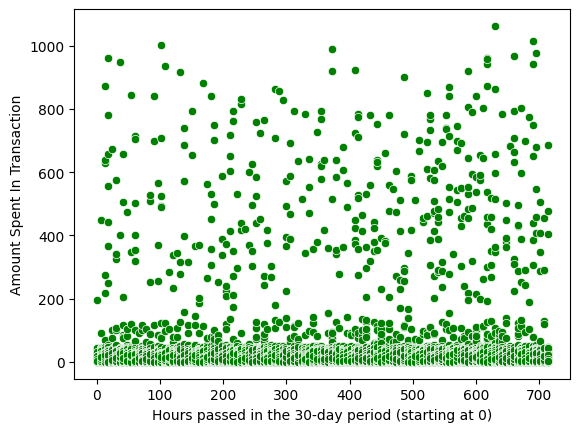

In [15]:
sns.scatterplot(data = transactions, x = "time", y = "money_spent", color = "green")
plt.ylabel("Amount Spent In Transaction")
plt.xlabel("Hours passed in the 30-day period (starting at 0)")

* As the number of hours increases (from start to the end of the trial or campaign), most customers spend less amount of money

In [16]:
#Maximum hours in the month. Therefore the closer to this time, the latter the transation or offer event
max_hours = 30*24

In [17]:
# Transaction per customer
transactions_per_customer = transactions.groupby("customer_id").agg(
    {
        "money_spent": lambda x: x.sum(),
        "event": lambda x: x.count(),
        "time": lambda x: max_hours - x.max(),
    }
).reset_index()

transactions_per_customer.rename(columns={"money_spent": "money", "event": "frequency", "time" :"recency"}, inplace=True)

transactions_per_customer.head()

,customer_id,money,frequency,recency
0,0009655768c64bdeb2e877511632db8f,127.60,8,24
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,12
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,24


## Explore offer received

In [18]:
offers_received.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [19]:
offers_received.isna().sum()

customer_id    0
event          0
value          0
time           0
dtype: int64

In [20]:
# unpack value column
offer_ids = []
for offer_id in offers_received["value"].values:
    offer_id = ast.literal_eval(offer_id)
    offer_ids.append(offer_id["offer id"])

offer_ids[:10]

['9b98b8c7a33c4b65b9aebfe6a799e6d9',
 '2906b810c7d4411798c6938adc9daaa5',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 '3f207df678b143eea3cee63160fa8bed',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '3f207df678b143eea3cee63160fa8bed',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 'fafdcd668e3743c1bb461111dcafc2a4']

In [21]:
offers_received["offer_received"] = offer_ids
offers_received = offers_received.drop(["value"], axis=1)
offers_received.head()

,customer_id,event,time,offer_received
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [22]:
# offers per customer
n_offers_per_customer = offers_received.groupby("customer_id").agg({
    "time": lambda x: max_hours - x.max(),
    "offer_received": lambda x: x.count()
}).reset_index()

n_offers_per_customer.rename(columns={"time": "time_for_latest_offer"}, inplace=True)

n_offers_per_customer.head()

,customer_id,time_for_latest_offer,offer_received
0,0009655768c64bdeb2e877511632db8f,144,5
1,0011e0d4e6b944f998e987f904e8c1e5,216,5
2,0020c2b971eb4e9188eac86d93036a77,216,5
3,0020ccbbb6d84e358d3414a3ff76cffd,216,4
4,003d66b6608740288d6cc97a6903f4f0,216,5


In [23]:
transactions_per_customer.shape

(14492, 4)

In [24]:
n_offers_per_customer.head()

,customer_id,time_for_latest_offer,offer_received
0,0009655768c64bdeb2e877511632db8f,144,5
1,0011e0d4e6b944f998e987f904e8c1e5,216,5
2,0020c2b971eb4e9188eac86d93036a77,216,5
3,0020ccbbb6d84e358d3414a3ff76cffd,216,4
4,003d66b6608740288d6cc97a6903f4f0,216,5


**Did everyone receive an offer?**

In [25]:
customers_transactions = transactions_per_customer["customer_id"].unique()
customers_offers_received = n_offers_per_customer["customer_id"].unique()

In [26]:
len(customers_transactions) == len(customers_offers_received)

False

In [27]:
len(customers_transactions), len(customers_offers_received)

(14492, 14820)

In [28]:
customers_with_no_offers = []

for customer in customers_offers_received:
    if customer not in customers_transactions:
        customers_with_no_offers.append(customer)

len(customers_with_no_offers)

333

* 333 of customers received an offer but have not history of transaction

## Customers Transactions vs Offers Received

In [29]:
#number of offers a customer received and the money spent (RFM)
df_00 =  n_offers_per_customer.set_index("customer_id").join(transactions_per_customer.set_index("customer_id"))
df_00.head()

,time_for_latest_offer,offer_received,money,frequency,recency
customer_id,,,,,
0009655768c64bdeb2e877511632db8f,144,5,127.60,8.0,24.0
0011e0d4e6b944f998e987f904e8c1e5,216,5,79.46,5.0,66.0
0020c2b971eb4e9188eac86d93036a77,216,5,196.86,8.0,12.0
0020ccbbb6d84e358d3414a3ff76cffd,216,4,154.05,12.0,48.0
003d66b6608740288d6cc97a6903f4f0,216,5,48.34,18.0,24.0


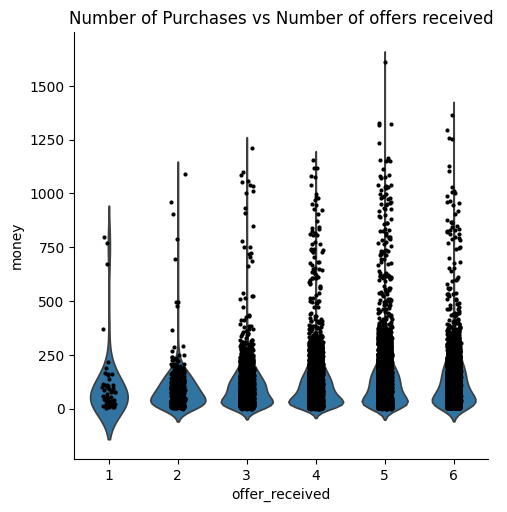

In [30]:
g = sns.catplot(data=df_00, x="offer_received", y="money", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="money", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

The more money you spent the higher the number of offers you received

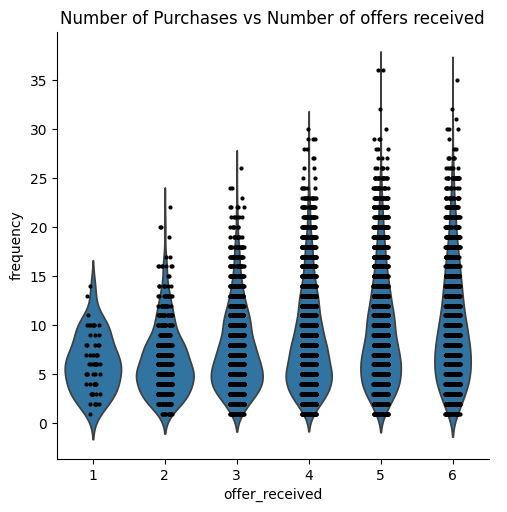

In [31]:
g = sns.catplot(data=df_00, x="offer_received", y="frequency", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="frequency", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

The more you buy, the higher the amount of offers received

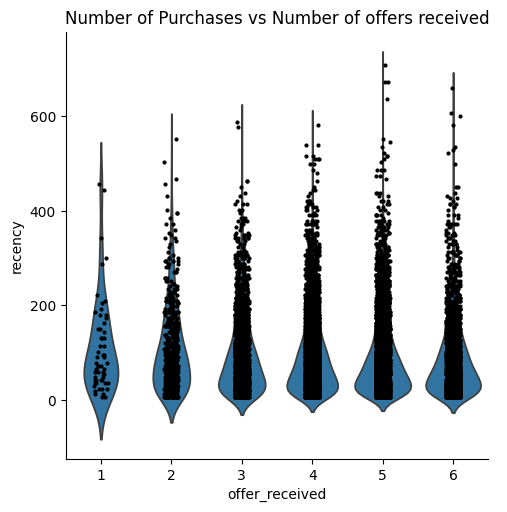

In [32]:
g = sns.catplot(data=df_00, x="offer_received", y="recency", kind="violin", inner=None)
sns.stripplot(data=df_00, x="offer_received", y="recency", color="k", size=3, ax=g.ax)
plt.title("Number of Purchases vs Number of offers received")
plt.show()

Those who bought more recently (low number on the scale) got less offers than those who last bought long time ago

## Explore Offers Viewed

In [33]:
offers_viewed.head()

,customer_id,event,value,time
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0


In [34]:
offers_viewed_ids = []

for offer in offers_viewed["value"].values:
    offer = ast.literal_eval(offer)
    offers_viewed_ids.append(offer["offer id"])

offers_viewed_ids[:10]

['f19421c1d4aa40978ebb69ca19b0e20d',
 '5a8bc65990b245e5a138643cd4eb9837',
 '4d5c57ea9a6940dd891ad53e9dbe8da0',
 'ae264e3637204a6fb9bb56bc8210ddfd',
 '5a8bc65990b245e5a138643cd4eb9837',
 '2906b810c7d4411798c6938adc9daaa5',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 '2298d6c36e964ae4a3e7e9706d1fb8c2',
 'f19421c1d4aa40978ebb69ca19b0e20d',
 'ae264e3637204a6fb9bb56bc8210ddfd']

In [35]:
offers_viewed["offer_id"] = offers_viewed_ids
offers_viewed = offers_viewed.drop(["value"], axis=1)
offers_viewed.head()

,customer_id,event,time,offer_id
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,5a8bc65990b245e5a138643cd4eb9837


In [36]:
offers_viewed_per_customer = offers_viewed.groupby(["customer_id"]).agg({
    "time": lambda x: max_hours - x.max(),
    "offer_id": lambda x: x.count()
}).reset_index()

offers_viewed_per_customer.rename(columns={"time": "time_last_offer_viewed", "offer_id": "offers_viewed"}, inplace=True)

offers_viewed_per_customer.head()

,customer_id,time_last_offer_viewed,offers_viewed
0,0009655768c64bdeb2e877511632db8f,180,4
1,0011e0d4e6b944f998e987f904e8c1e5,204,5
2,0020c2b971eb4e9188eac86d93036a77,60,3
3,0020ccbbb6d84e358d3414a3ff76cffd,138,4
4,003d66b6608740288d6cc97a6903f4f0,300,4


## Not all customers viewed offers received

In [37]:
customers_offers_viewed = offers_viewed_per_customer["customer_id"].unique()
customers_offers_received = n_offers_per_customer["customer_id"].unique()

In [38]:
len(customers_offers_received) == len(customers_offers_viewed)

False

In [39]:
customers_without_offer_viewed = []

for customer in customers_offers_received:
    if customer not in customers_offers_viewed:
        customers_without_offer_viewed.append(customer)

len(customers_without_offer_viewed)

145

* 145 Customers did not view their offers after receiving them

## Explore offers Completed

In [40]:
offers_completed.head()

,customer_id,event,value,time
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0


In [41]:
offers_completed["value"].values[0]

"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}"

In [42]:
rewards = []
completed_offers_ids = []

for offer in offers_completed["value"].values:
    offer = ast.literal_eval(offer)
    rewards.append(offer["reward"])
    completed_offers_ids.append(offer["offer_id"])

In [43]:
offers_completed["rewards"] = rewards
offers_completed["offer_id"] = completed_offers_ids
offers_completed.drop(["value"], axis=1, inplace=True)
offers_completed.head()

,customer_id,event,time,rewards,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,2,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,2,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,5,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,10,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,10,4d5c57ea9a6940dd891ad53e9dbe8da0


In [44]:
n_offers_completed_per_customer = offers_completed.groupby("customer_id").agg({
        "offer_id": lambda x: x.count(),
        "rewards": lambda x: x.sum(),
        "time": lambda x: max_hours - x.max()
    }
).reset_index()

n_offers_completed_per_customer.rename(columns={"offer_id": "offers_completed", "time": "time_last_offer_completed"}, inplace=True)

n_offers_completed_per_customer.head()

,customer_id,offers_completed,rewards,time_last_offer_completed
0,0009655768c64bdeb2e877511632db8f,3,9,144
1,0011e0d4e6b944f998e987f904e8c1e5,3,13,144
2,0020c2b971eb4e9188eac86d93036a77,3,14,210
3,0020ccbbb6d84e358d3414a3ff76cffd,3,13,120
4,003d66b6608740288d6cc97a6903f4f0,3,9,24


# Merge all the per customer tables

* transactions
* offers viewed
* offers received
* offers completed

In [45]:
transactions_per_customer.head()

,customer_id,money,frequency,recency
0,0009655768c64bdeb2e877511632db8f,127.60,8,24
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,12
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,24


In [46]:
n_offers_per_customer.head()

,customer_id,time_for_latest_offer,offer_received
0,0009655768c64bdeb2e877511632db8f,144,5
1,0011e0d4e6b944f998e987f904e8c1e5,216,5
2,0020c2b971eb4e9188eac86d93036a77,216,5
3,0020ccbbb6d84e358d3414a3ff76cffd,216,4
4,003d66b6608740288d6cc97a6903f4f0,216,5


In [47]:
offers_viewed_per_customer.head()

,customer_id,time_last_offer_viewed,offers_viewed
0,0009655768c64bdeb2e877511632db8f,180,4
1,0011e0d4e6b944f998e987f904e8c1e5,204,5
2,0020c2b971eb4e9188eac86d93036a77,60,3
3,0020ccbbb6d84e358d3414a3ff76cffd,138,4
4,003d66b6608740288d6cc97a6903f4f0,300,4


In [48]:
n_offers_completed_per_customer.head()

,customer_id,offers_completed,rewards,time_last_offer_completed
0,0009655768c64bdeb2e877511632db8f,3,9,144
1,0011e0d4e6b944f998e987f904e8c1e5,3,13,144
2,0020c2b971eb4e9188eac86d93036a77,3,14,210
3,0020ccbbb6d84e358d3414a3ff76cffd,3,13,120
4,003d66b6608740288d6cc97a6903f4f0,3,9,24


**Copies of tables**

In [49]:
df_t = transactions_per_customer.copy() #transactions
df_or = n_offers_per_customer.copy()  # offers received
df_ov = offers_viewed_per_customer.copy()  # offers viewed
df_oc = n_offers_completed_per_customer.copy()  # offers completed

In [50]:
rfm_ext = df_t.set_index("customer_id").join(df_or.set_index("customer_id")).join(df_ov.set_index("customer_id")).join(df_oc.set_index("customer_id"))
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed
customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,144.0,5.0,180.0,4.0,3.0,9.0,144.0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,216.0,5.0,204.0,5.0,3.0,13.0,144.0
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,216.0,5.0,60.0,3.0,3.0,14.0,210.0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,216.0,4.0,138.0,4.0,3.0,13.0,120.0
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,216.0,5.0,300.0,4.0,3.0,9.0,24.0


In [51]:
rfm_ext.isna().sum()

money                           0
frequency                       0
recency                         0
time_for_latest_offer           5
offer_received                  5
time_last_offer_viewed        140
offers_viewed                 140
offers_completed             2506
rewards                      2506
time_last_offer_completed    2506
dtype: int64

In [52]:
rfm_ext = rfm_ext.fillna(0)
rfm_ext.isna().sum()

money                        0
frequency                    0
recency                      0
time_for_latest_offer        0
offer_received               0
time_last_offer_viewed       0
offers_viewed                0
offers_completed             0
rewards                      0
time_last_offer_completed    0
dtype: int64

## Add Customer Details

In [53]:
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


In [54]:
rfm_ext = rfm_ext.join(customers.set_index("customer_id"))
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,became_member_on,gender,age,income
customer_id,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,144.0,5.0,180.0,4.0,3.0,9.0,144.0,2017-04-21,M,33,72000.0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,216.0,5.0,204.0,5.0,3.0,13.0,144.0,2018-01-09,O,40,57000.0
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,216.0,5.0,60.0,3.0,3.0,14.0,210.0,2016-03-04,F,59,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,216.0,4.0,138.0,4.0,3.0,13.0,120.0,2016-11-11,F,24,60000.0
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,216.0,5.0,300.0,4.0,3.0,9.0,24.0,2017-06-21,F,26,73000.0


**Change the day of joining to number of days before the Trial starts**

Assuming trial start date of 01 August 2018

In [55]:
# Assume that the project ran between 01 and 30 August 2018. Therefore find how many days a customer join before the begining of the trial
last_joining_date = pd.to_datetime("2018-08-01")
last_joining_date

Timestamp('2018-08-01 00:00:00')

In [56]:
rfm_ext["joined_days"] = rfm_ext["became_member_on"].apply(lambda x: last_joining_date - x)
rfm_ext["joined_days"] = rfm_ext["joined_days"].dt.days
rfm_ext.drop(["became_member_on"], axis=1, inplace=True)
rfm_ext.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender,age,income,joined_days
customer_id,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,144.0,5.0,180.0,4.0,3.0,9.0,144.0,M,33,72000.0,467
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,216.0,5.0,204.0,5.0,3.0,13.0,144.0,O,40,57000.0,204
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,216.0,5.0,60.0,3.0,3.0,14.0,210.0,F,59,90000.0,880
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,216.0,4.0,138.0,4.0,3.0,13.0,120.0,F,24,60000.0,628
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,216.0,5.0,300.0,4.0,3.0,9.0,24.0,F,26,73000.0,406


In [57]:
rfm_ext.isna().sum()

money                        0
frequency                    0
recency                      0
time_for_latest_offer        0
offer_received               0
time_last_offer_viewed       0
offers_viewed                0
offers_completed             0
rewards                      0
time_last_offer_completed    0
gender                       0
age                          0
income                       0
joined_days                  0
dtype: int64

# Data Preparation for Clustering

## One Hot Encode Gender

In [58]:
# Apply OneHotEncoder On Gender
ce_OHE = OneHotEncoder(cols=["gender"], use_cat_names=True, drop_invariant=True)
ce_OHE

OneHotEncoder(cols=['gender'], drop_invariant=True, use_cat_names=True)

In [59]:
rfm_encoded = ce_OHE.fit_transform(rfm_ext)
rfm_encoded.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender_M,gender_O,gender_F,age,income,joined_days
customer_id,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,144.0,5.0,180.0,4.0,3.0,9.0,144.0,1,0,0,33,72000.0,467
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,216.0,5.0,204.0,5.0,3.0,13.0,144.0,0,1,0,40,57000.0,204
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,216.0,5.0,60.0,3.0,3.0,14.0,210.0,0,0,1,59,90000.0,880
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,216.0,4.0,138.0,4.0,3.0,13.0,120.0,0,0,1,24,60000.0,628
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,216.0,5.0,300.0,4.0,3.0,9.0,24.0,0,0,1,26,73000.0,406


## Scale the data

In [60]:
X = rfm_encoded.copy()

In [61]:
cols_to_scale = [
    "money",
    "frequency",
    "recency",
    "time_for_latest_offer",
    "offer_received",
    "time_last_offer_viewed",
    "offers_viewed",
    "offers_completed",
    "rewards",
    "time_last_offer_completed",
    "age",
    "income",
    "joined_days",
]

In [62]:
sc = StandardScaler()
X[cols_to_scale] = sc.fit_transform(X[cols_to_scale])
X.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender_M,gender_O,gender_F,age,income,joined_days
customer_id,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.060536,-0.108898,-0.811158,-0.459486,0.478153,0.046813,0.496417,0.486532,-0.224936,-0.099617,1,0,0,-1.222085,0.313998,-0.162455
0011e0d4e6b944f998e987f904e8c1e5,-0.309160,-0.699157,-0.295665,0.825597,0.478153,0.269280,1.274660,0.486532,0.208069,-0.099617,0,1,0,-0.820576,-0.380495,-0.788394
0020c2b971eb4e9188eac86d93036a77,0.592426,-0.108898,-0.958442,0.825597,0.478153,-1.065524,-0.281826,0.486532,0.316320,0.354243,0,0,1,0.269235,1.147389,0.820483
0020ccbbb6d84e358d3414a3ff76cffd,0.263662,0.678113,-0.516591,0.825597,-0.453217,-0.342505,0.496417,0.486532,0.208069,-0.264657,0,0,1,-1.738311,-0.241596,0.220724
003d66b6608740288d6cc97a6903f4f0,-0.548149,1.858629,-0.811158,0.825597,0.478153,1.159150,0.496417,0.486532,-0.224936,-0.924816,0,0,1,-1.623594,0.360297,-0.307635


In [63]:
X_scaled = X.copy()

# Perform K-Clustering

## Elbow Method and Silhouette Score

In [64]:
# Range of k values to try
k_values = range(1, 20)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    labels = kmeans.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X.values, labels)
        silhouette_scores.append(score)

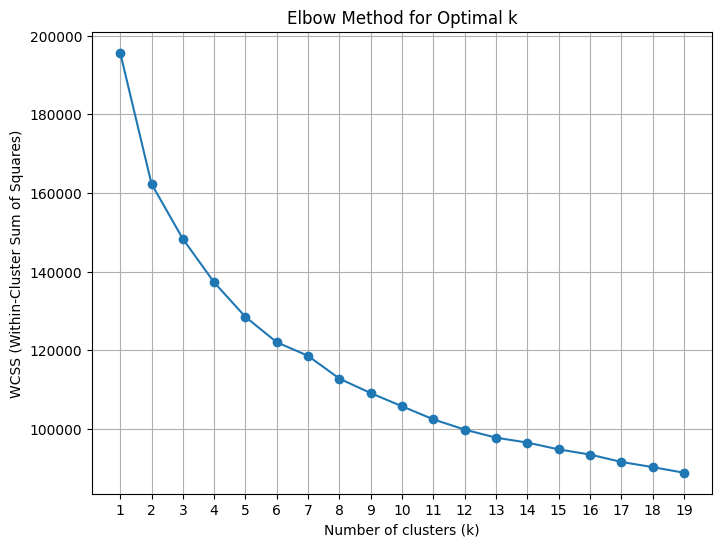

In [65]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks([x for x in k_values])
plt.grid(True)
plt.show()

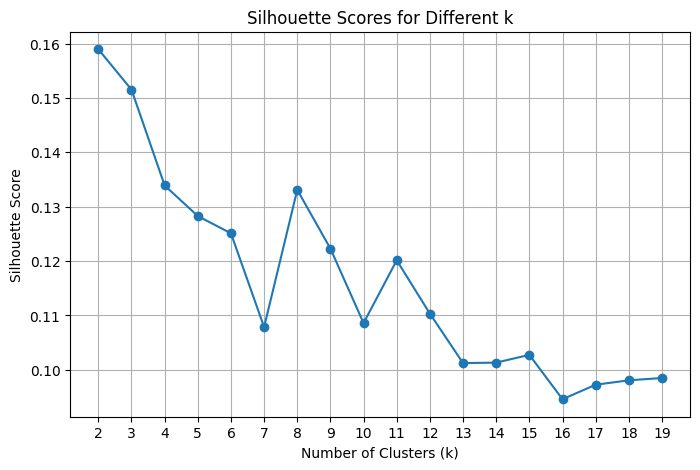

In [66]:
# Plot silhouette scores
k_range = range(2, 20)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks([x for x in k_range])
plt.grid(True)
plt.show()

* It is not so easy to identify the best number of clusters in the above plots. There will have to perform trial and error till best number of clusters are identified.
* Alternatively, as completed in the next section, perform PCA and then do clustering after

## Fit the Model

In [67]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(X)

KMeans(n_clusters=3, random_state=0)

In [68]:
X["Cluster"] = model.labels_

In [69]:
centroids = model.cluster_centers_

In [70]:
X.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender_M,gender_O,gender_F,age,income,joined_days,Cluster
customer_id,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.060536,-0.108898,-0.811158,-0.459486,0.478153,0.046813,0.496417,0.486532,-0.224936,-0.099617,1,0,0,-1.222085,0.313998,-0.162455,2
0011e0d4e6b944f998e987f904e8c1e5,-0.309160,-0.699157,-0.295665,0.825597,0.478153,0.269280,1.274660,0.486532,0.208069,-0.099617,0,1,0,-0.820576,-0.380495,-0.788394,2
0020c2b971eb4e9188eac86d93036a77,0.592426,-0.108898,-0.958442,0.825597,0.478153,-1.065524,-0.281826,0.486532,0.316320,0.354243,0,0,1,0.269235,1.147389,0.820483,2
0020ccbbb6d84e358d3414a3ff76cffd,0.263662,0.678113,-0.516591,0.825597,-0.453217,-0.342505,0.496417,0.486532,0.208069,-0.264657,0,0,1,-1.738311,-0.241596,0.220724,2
003d66b6608740288d6cc97a6903f4f0,-0.548149,1.858629,-0.811158,0.825597,0.478153,1.159150,0.496417,0.486532,-0.224936,-0.924816,0,0,1,-1.623594,0.360297,-0.307635,2


## Snake Plot

In [71]:
cols_to_plot = ["recency", "frequency", "money"]

In [72]:
X_melted = pd.melt(
    X.reset_index(),
    id_vars=["Cluster"],
    value_vars=cols_to_plot,
    var_name="Attribute",
    value_name="Value",
)

X_melted.head()

,Cluster,Attribute,Value
0,2,recency,-0.811158
1,2,recency,-0.295665
2,2,recency,-0.958442
3,2,recency,-0.516591
4,2,recency,-0.811158


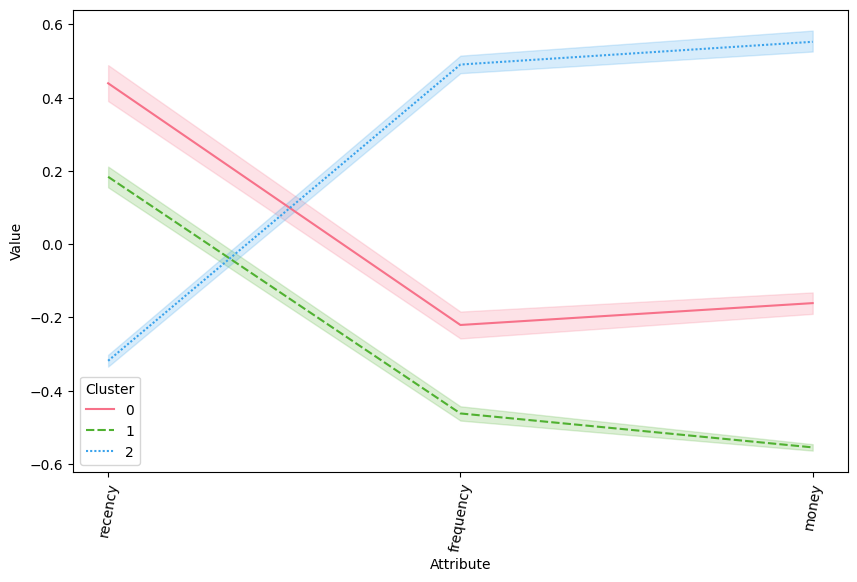

In [73]:
palette = sns.color_palette("husl", n_colors=X_melted["Cluster"].nunique())

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=X_melted,
    x="Attribute",
    y="Value",
    style="Cluster",
    palette=palette,
    hue="Cluster",
)
plt.xticks(rotation=80)
plt.show()

## Cluster Visualization

In [74]:
# 2D scatter plot (if you reduce dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X["pca1"] = X_pca[:, 0]
X["pca2"] = X_pca[:, 1]

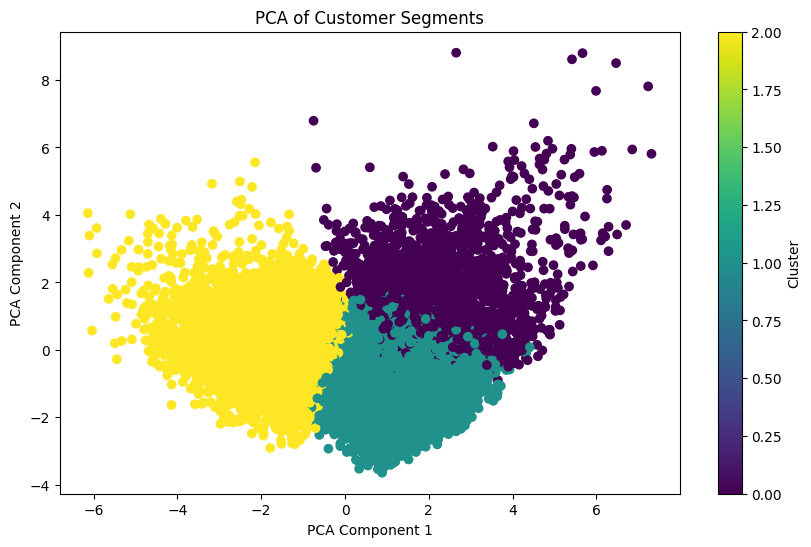

In [75]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X["pca1"], X["pca2"], c=X["Cluster"], cmap="viridis")
plt.colorbar(scatter, label="Cluster")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Customer Segments")
plt.show()

# PCA Before Clustering

In [76]:
X = X_scaled.copy()

In [77]:
# 2D scatter plot (if you reduce dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

## Elbow Method and Silhouette Score

In [78]:
# Range of k values to try
k_values = range(1, 20)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    labels = kmeans.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

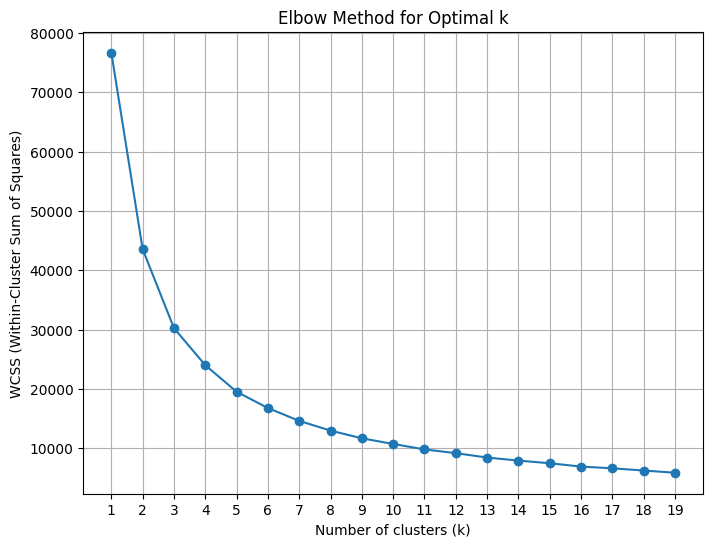

In [79]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks([x for x in k_values])
plt.grid(True)
plt.show()

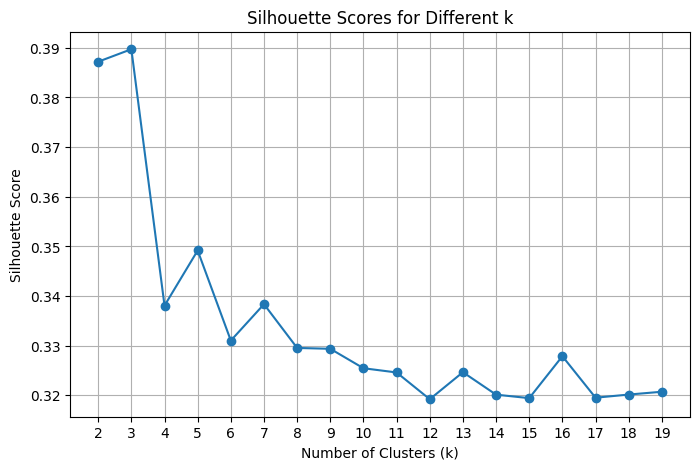

In [80]:
# Plot silhouette scores
k_range = range(2, 20)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks([x for x in k_range])
plt.grid(True)
plt.show()

* This step of PCA followed by clustering seems to indicate the best numbers of clusters much easier
* According to the above elbow method and silhouette score, a k = 3 is the best number of clusters

## Fit the Model

In [81]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(X_pca)

KMeans(n_clusters=3, random_state=0)

In [82]:
clusters = model.labels_

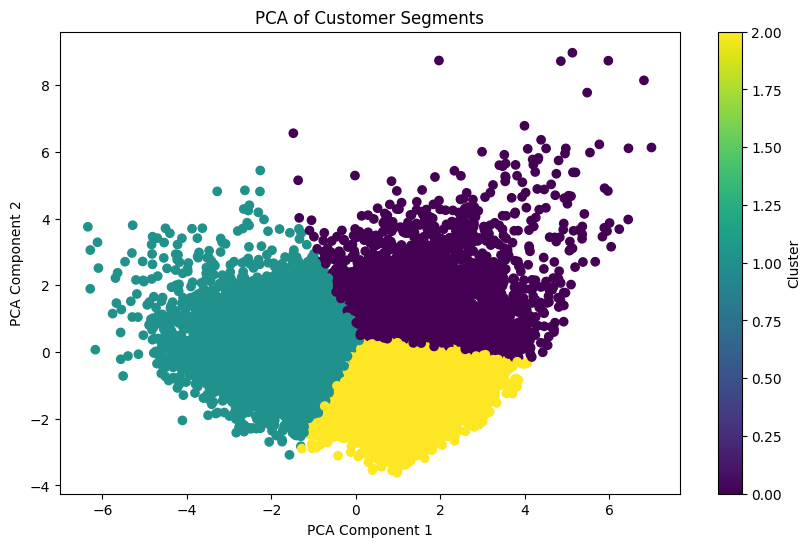

In [83]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.colorbar(scatter, label="Cluster")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Customer Segments")
plt.show()

## Snake Plot

In [84]:
X["Cluster"] = clusters
X.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender_M,gender_O,gender_F,age,income,joined_days,Cluster
customer_id,,,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,0.060536,-0.108898,-0.811158,-0.459486,0.478153,0.046813,0.496417,0.486532,-0.224936,-0.099617,1,0,0,-1.222085,0.313998,-0.162455,1
0011e0d4e6b944f998e987f904e8c1e5,-0.309160,-0.699157,-0.295665,0.825597,0.478153,0.269280,1.274660,0.486532,0.208069,-0.099617,0,1,0,-0.820576,-0.380495,-0.788394,2
0020c2b971eb4e9188eac86d93036a77,0.592426,-0.108898,-0.958442,0.825597,0.478153,-1.065524,-0.281826,0.486532,0.316320,0.354243,0,0,1,0.269235,1.147389,0.820483,1
0020ccbbb6d84e358d3414a3ff76cffd,0.263662,0.678113,-0.516591,0.825597,-0.453217,-0.342505,0.496417,0.486532,0.208069,-0.264657,0,0,1,-1.738311,-0.241596,0.220724,1
003d66b6608740288d6cc97a6903f4f0,-0.548149,1.858629,-0.811158,0.825597,0.478153,1.159150,0.496417,0.486532,-0.224936,-0.924816,0,0,1,-1.623594,0.360297,-0.307635,1


In [85]:
X_melted = pd.melt(
    X.reset_index(),
    id_vars=["Cluster"],
    value_vars=cols_to_plot,
    var_name="Attribute",
    value_name="Value",
)

X_melted.head()

,Cluster,Attribute,Value
0,1,recency,-0.811158
1,2,recency,-0.295665
2,1,recency,-0.958442
3,1,recency,-0.516591
4,1,recency,-0.811158


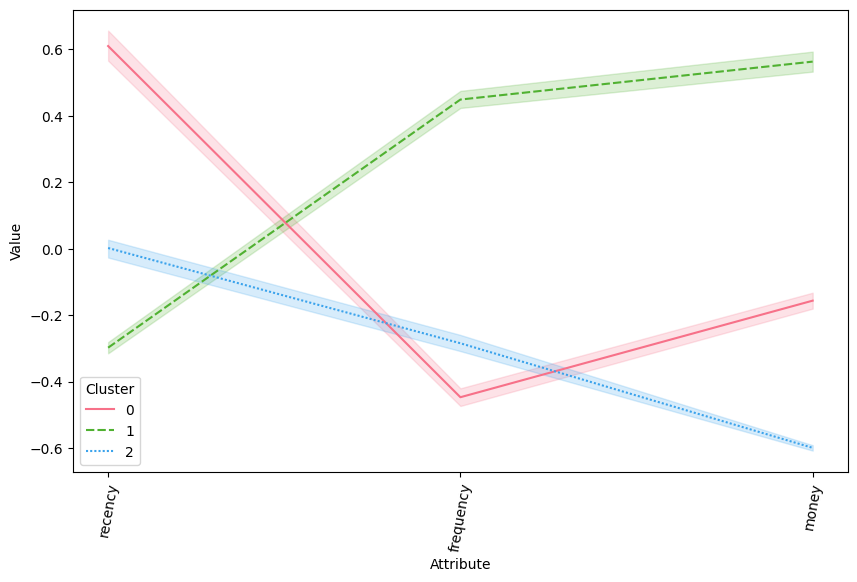

In [86]:
palette = sns.color_palette("husl", n_colors=X_melted["Cluster"].nunique())

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=X_melted,
    x="Attribute",
    y="Value",
    style="Cluster",
    palette=palette,
    hue="Cluster",
)
plt.xticks(rotation=80)
plt.show()

**Customer Clusters:**

* Cluster 0: Last bought long time ago, have lowest purchase frequency and spend low amount of money (Lost or churned customers)
* Cluster 1: Last bought more recently, have highest purchase frequency  and spend the highest amount (Loyal Customers -  keep coming and buying)
* Clsuter 3: Last bought recently, have low purcharse frequency and spent lowest amount of money (At risk customer - we might loose them)

# EDA for Each Cluster

In [87]:
#Copy of rfm extended
df = rfm_ext.copy()

In [88]:
#adding clusters to the original data
df["cluster"] = clusters
df.head()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,gender,age,income,joined_days,cluster
customer_id,,,,,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,144.0,5.0,180.0,4.0,3.0,9.0,144.0,M,33,72000.0,467,1
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,216.0,5.0,204.0,5.0,3.0,13.0,144.0,O,40,57000.0,204,2
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,216.0,5.0,60.0,3.0,3.0,14.0,210.0,F,59,90000.0,880,1
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,216.0,4.0,138.0,4.0,3.0,13.0,120.0,F,24,60000.0,628,1
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,216.0,5.0,300.0,4.0,3.0,9.0,24.0,F,26,73000.0,406,1


## Clusters summary stats

In [89]:
df["cluster"].value_counts()

cluster
1    6306
2    5119
0    3067
Name: count, dtype: int64

In [90]:
df["cluster"].value_counts(normalize=True)

cluster
1    0.435137
2    0.353229
0    0.211634
Name: proportion, dtype: float64

* Cluster 1 had more customers (43%) while cluster 0 has lowest number of customers (21%)

In [91]:
df_c1 = df[df["cluster"] == 0]
df_c2 = df[df["cluster"] == 1]
df_c3 = df[df["cluster"] == 2]

In [92]:
df_c1.describe()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,age,income,joined_days,cluster
count,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.000000,3067.0
mean,99.330522,6.280404,139.772416,225.750245,3.477013,274.266710,2.307141,1.611347,7.863058,261.034235,59.493968,73922.725791,519.290186,0.0
std,89.807276,3.855125,105.275839,89.797476,0.986062,153.376328,0.995861,0.977357,5.994085,183.745079,15.837674,21970.052306,403.355806,0.0
min,0.280000,1.000000,6.000000,144.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,6.000000,0.0
25%,40.445000,4.000000,60.000000,144.000000,3.000000,168.000000,2.000000,1.000000,3.000000,132.000000,50.000000,57000.000000,219.000000,0.0
50%,83.270000,5.000000,120.000000,216.000000,3.000000,240.000000,2.000000,2.000000,7.000000,246.000000,60.000000,74000.000000,365.000000,0.0
75%,135.085000,8.000000,198.000000,312.000000,4.000000,348.000000,3.000000,2.000000,12.000000,360.000000,70.000000,91000.000000,784.500000,0.0
max,1058.240000,24.000000,708.000000,720.000000,6.000000,720.000000,6.000000,5.000000,35.000000,720.000000,101.000000,120000.000000,1828.000000,0.0


In [93]:
df_c2.describe()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,age,income,joined_days,cluster
count,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.000000,6306.0
mean,193.016564,10.834126,65.799239,153.457659,4.977799,140.806851,4.070568,3.590549,18.518078,142.531874,56.882176,71128.766254,656.139391,1.0
std,152.595669,5.134426,52.870824,25.453355,0.800564,59.293828,1.067254,1.029216,7.728506,84.399868,16.528444,21113.009027,402.792834,0.0
min,11.300000,1.000000,6.000000,144.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,6.000000,1.0
25%,109.050000,7.000000,24.000000,144.000000,4.000000,114.000000,3.000000,3.000000,13.000000,90.000000,47.000000,55000.000000,322.250000,1.0
50%,160.890000,10.000000,54.000000,144.000000,5.000000,138.000000,4.000000,4.000000,18.000000,126.000000,57.000000,70000.000000,618.000000,1.0
75%,225.275000,14.000000,90.000000,144.000000,6.000000,144.000000,5.000000,4.000000,23.000000,180.000000,68.000000,86000.000000,915.750000,1.0
max,1608.690000,36.000000,384.000000,312.000000,6.000000,552.000000,6.000000,6.000000,55.000000,720.000000,101.000000,120000.000000,1829.000000,1.0


In [94]:
df_c3.describe()

,money,frequency,recency,time_for_latest_offer,offer_received,time_last_offer_viewed,offers_viewed,offers_completed,rewards,time_last_offer_completed,age,income,joined_days,cluster
count,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.000000,5119.0
mean,41.635718,7.105880,90.244970,156.250830,4.486423,157.504981,3.121508,0.949404,3.838640,116.699355,48.024419,52721.625317,395.915218,2.0
std,39.083034,4.490505,80.668592,29.516509,0.992036,82.942003,1.155244,0.951120,4.440011,150.052298,17.609036,15426.364034,406.176286,0.0
min,0.150000,1.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,6.000000,2.0
25%,15.245000,4.000000,30.000000,144.000000,4.000000,114.000000,2.000000,0.000000,0.000000,0.000000,33.000000,40000.000000,141.000000,2.0
50%,28.330000,6.000000,66.000000,144.000000,5.000000,138.000000,3.000000,1.000000,2.000000,60.000000,48.000000,51000.000000,261.000000,2.0
75%,54.680000,9.000000,126.000000,144.000000,5.000000,198.000000,4.000000,2.000000,7.000000,186.000000,61.000000,63000.000000,423.500000,2.0
max,472.660000,27.000000,672.000000,384.000000,6.000000,720.000000,6.000000,4.000000,25.000000,720.000000,100.000000,115000.000000,1819.000000,2.0


In [95]:
df_c1.describe(include="object")

,gender
count,3067
unique,3
top,F
freq,1525


In [96]:
df_c2.describe(include="object")

,gender
count,6306
unique,3
top,F
freq,3138


In [97]:
df_c3.describe(include="object")

,gender
count,5119
unique,3
top,M
freq,3719


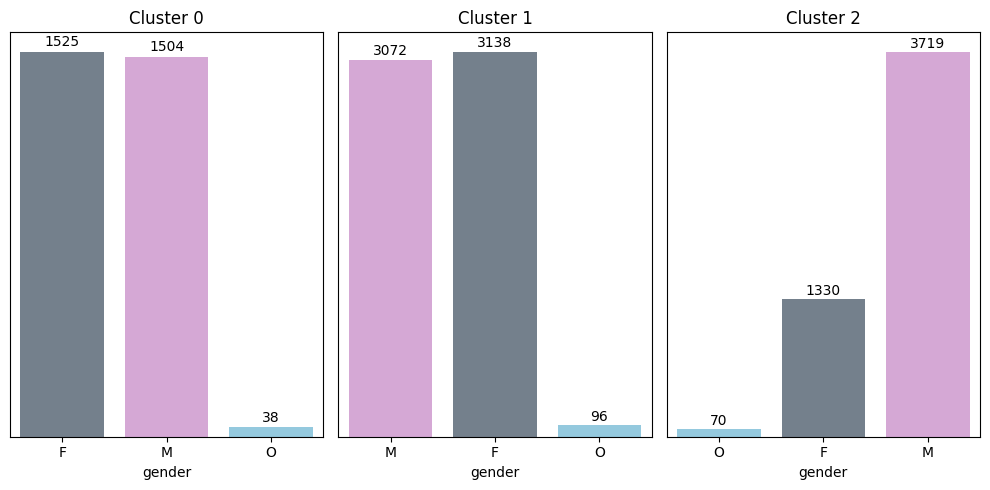

In [98]:
gender_palette = {
    "M": "plum",  # Color for Male
    "F": "slategray",  # Color for Female
    "O": "skyblue",  # Color for Other
}
fig, axs = plt.subplots(1,3, figsize = (10,5))
sns.countplot(data=df_c1, x="gender", stat="count", palette=gender_palette, hue="gender", ax = axs[0])
sns.countplot(data=df_c2, x="gender", stat="count", palette=gender_palette, hue="gender", ax=axs[1])
sns.countplot(data=df_c3, x="gender", stat="count", palette=gender_palette, hue="gender", ax=axs[2])

# Remove y-axis labels and tick marks
for ax in axs:
    ax.yaxis.set_visible(False)  # Hides the y-axis line and labels
    ax.set_yticks([])  # Removes the tick marks


# Set titles
axs[0].set_title("Cluster 0")
axs[1].set_title("Cluster 1")
axs[2].set_title("Cluster 2")

# Add value labels on the bars
for ax in axs:
    for p in ax.patches:
        # Get the height of each bar
        height = p.get_height()
        # Add text label above each bar
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height + 10,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontsize=10,
            color="black",
            # fontweight="bold",
        )

plt.tight_layout()
plt.show()

**Gender:**

* Both cluster 0 and 1 are similarly dominated by males and females while cluster 2 is dominated by males only
* Other has the lowest number of representation in all clusters
* Cluster 1 has more customers as compared to other clusters

## Distribution In each cluster

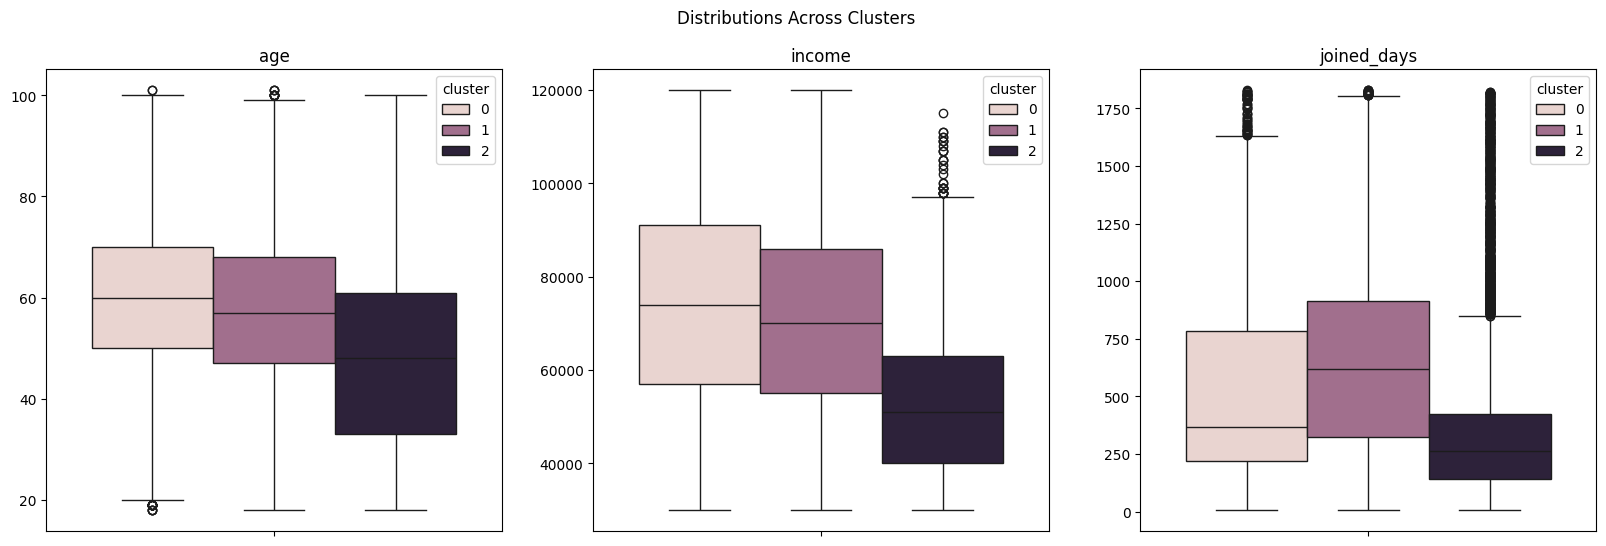

In [99]:
fig, axs = plt.subplots(1,3, figsize = (20,6))
sns.boxplot(data=df, y="age", hue="cluster", ax = axs[0])
sns.boxplot(data=df, y="income", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="joined_days", hue="cluster", ax=axs[2])

col_name = ["age","income", "joined_days"]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Most customers in cluster 0 are older compared to other clusters. Cluster 2 has lowest age average
* Most customers in cluster 0 have higher income compared to other clusters and cluster has lowest average income
* Most customers in cluster 1 joined the company some time ago while most of the customers in cluster 2 joined more recently

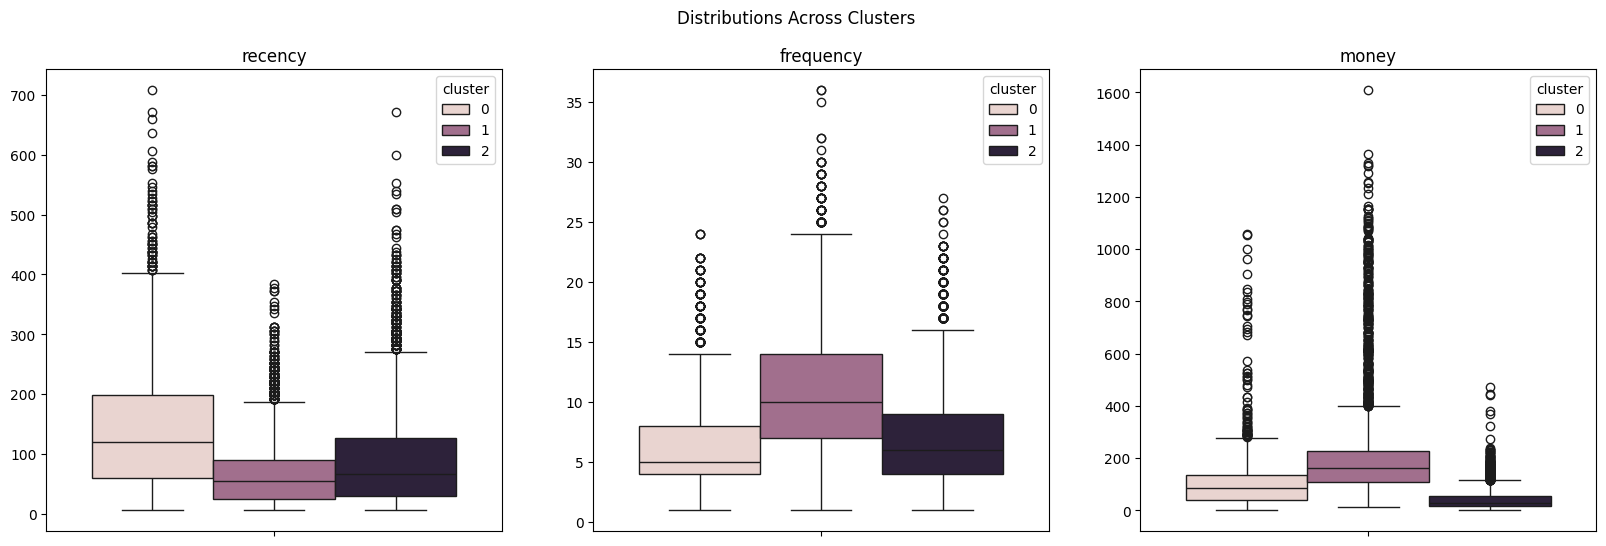

In [100]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="recency", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="frequency", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="money", hue="cluster", ax=axs[2])

col_name = ["recency","frequency","money",]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Most customers in cluster 0 has their latest purchases long time ago compared to others. Cluster 1 had most of their purchases more recently
* Most customers in cluster 0 bought less frequently while cluster 1 bought more frequently.
* Most customers in cluster 2 spent lesser money when buying while most of the customers in cluster 1 spent most money

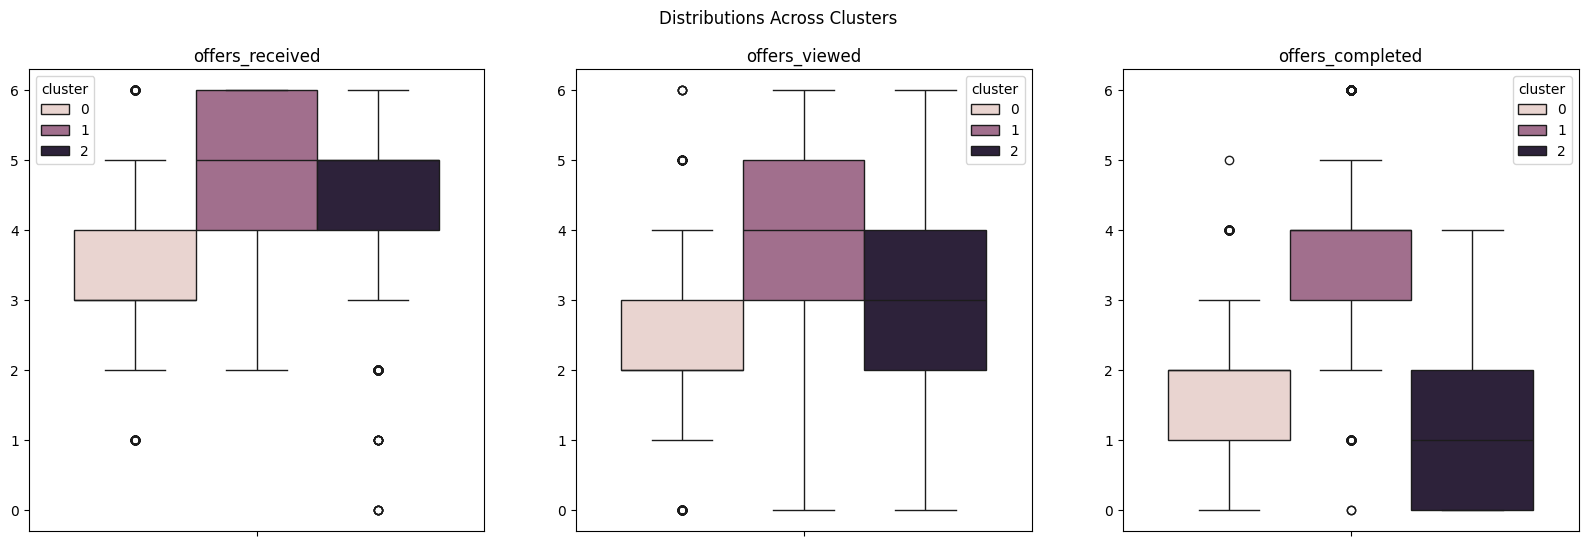

In [101]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="offer_received", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="offers_viewed", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="offers_completed", hue="cluster", ax=axs[2])

col_name = ["offers_received", "offers_viewed", "offers_completed"]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Most customers in cluster 0 has their latest purchases long time ago compared to others. Cluster 1 had most of their purchases more recently
* Most customers in cluster 0 bought less frequently while cluster 1 bought more frequently.
* Most customers in cluster 2 spent lesser money when buying while most of the customers in cluster 1 spent most money

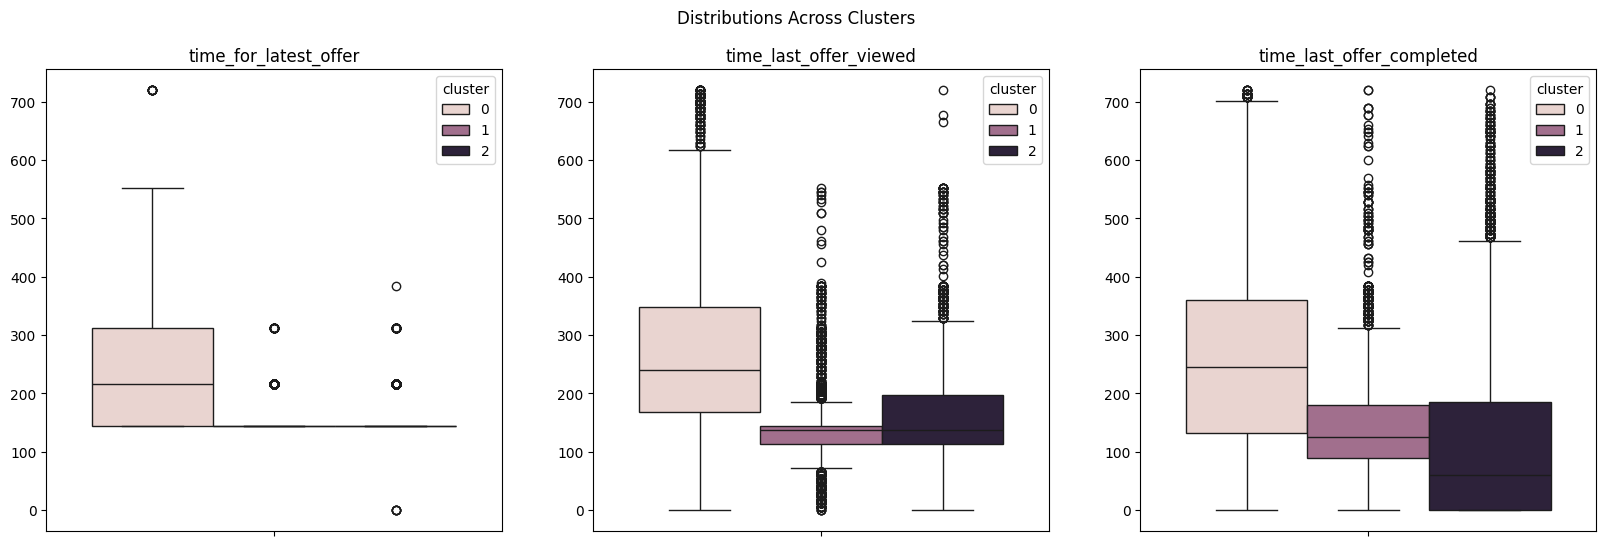

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=df, y="time_for_latest_offer", hue="cluster", ax=axs[0])
sns.boxplot(data=df, y="time_last_offer_viewed", hue="cluster", ax=axs[1])
sns.boxplot(data=df, y="time_last_offer_completed", hue="cluster", ax=axs[2])

col_name = [
    "time_for_latest_offer",
    "time_last_offer_viewed",
    "time_last_offer_completed",
]
for i, ax in enumerate(axs):
    ax.set_title(col_name[i])
    ax.set_ylabel("")

fig.suptitle("Distributions Across Clusters")
plt.show()

* Most customers in cluster 0 received the latest offer recently. Cluster 1 and 2 received their latest offers at the same time which is more recently compared to majority in cluster 0.
* Most customers in cluster 1 and 2 viewed their offers much later after receiving them while cluster 1 viewed them earlier.
* Most customers in cluster 2 completed their offers later closer to the closing date while most of the customers in cluster 0 completed their offers earlier

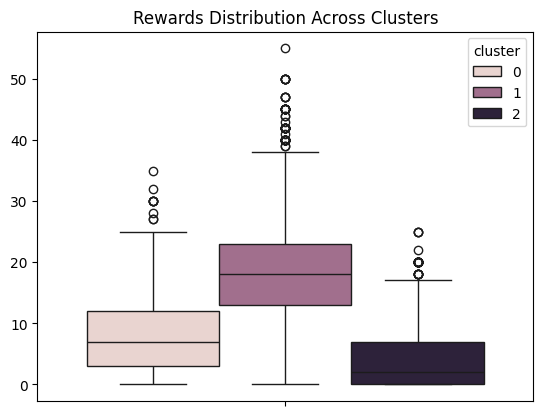

In [103]:
sns.boxplot(data=df, y="rewards", hue="cluster")
plt.title("Rewards Distribution Across Clusters")
plt.ylabel("")
plt.show()

* Most customers in cluster 1 gained most rewards (amount) compared to others. Cluster 1 had least rewards

**Is there an overlap of customer across clusters?**

In [104]:
customer_c1 = df_c1.index
customer_c2 = df_c2.index
customer_c3 = df_c3.index

In [105]:
for customer in customer_c1:
    if customer in customer_c2:
        print("Found in cluster 2")
    if customer in customer_c3:
        print("Found in cluster 3")

In [106]:
for customer in customer_c2:
    if customer in customer_c1:
        print("Found in cluster 1")
    if customer in customer_c3:
        print("Found in cluster 3")

In [107]:
for customer in customer_c3:
    if customer in customer_c1:
        print("Found in cluster 1")
    if customer in customer_c2:
        print("Found in cluster 2")

* No customers overlap into other clusters

# Offers Ratio

In [108]:
offers

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"['web', 'email', 'mobile']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']"


In [109]:
# function to consolidate the received, viewed and completed ratio

def ratio_calcs(customers_list):
    # offers received
    received = offers_received[offers_received["customer_id"].isin(customers_list)]
    received_agg = received.groupby("offer_received").agg({"event": lambda x:x.count()}).reset_index()

    # offers viewed
    viewed = offers_viewed[offers_viewed["customer_id"].isin(customers_list)]
    viewed_agg = viewed.groupby("offer_id").agg({"event": lambda x: x.count()}).reset_index()

    # offers completed
    completed = offers_completed[offers_completed["customer_id"].isin(customers_list)]
    completed_agg = completed.groupby("offer_id").agg({"event": lambda x: x.count()}).reset_index()

    # combine all three tables
    agg = received_agg.set_index("offer_received").join(viewed_agg.set_index("offer_id"), rsuffix="_v").join(completed_agg.set_index("offer_id"), rsuffix="_c")
    agg = agg.reset_index()
    agg.rename(columns={"offer_received": "offer_id", "event": "n_received", "event_v": "n_viewed", "event_c": "n_completed"}, inplace=True)

    # calculate ratios
    agg["viewed/received"] = 100 * agg["n_viewed"] / agg["n_received"]
    agg["completed/viewed"] = 100 * agg["n_completed"] / agg["n_viewed"]
    agg["completed/received"] = 100 * agg["n_completed"] / agg["n_received"]

    # get offers metadata
    agg_meta = agg.set_index("offer_id").join(offers.set_index("offer_id"))

    #create a readale name using offer_id and offer type
    offer_name = []
    for i, offer_type in enumerate(agg_meta.offer_type.values):
        name = offer_type + "_" + agg_meta.index[i][:3]
        offer_name.append(name)
    
    agg_meta["offer_name"] = offer_name
    agg_meta = agg_meta.reset_index()

    return agg_meta

In [110]:
offers_c1 = ratio_calcs(customer_c1)
offers_c1

,offer_id,n_received,n_viewed,n_completed,viewed/received,completed/viewed,completed/received,offer_type,difficulty,reward,duration,channels,offer_name
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1248,284,576.0,22.756410,202.816901,46.153846,discount,20,5,10,"['web', 'email']",discount_0b1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,967,926,712.0,95.760083,76.889849,73.629783,discount,7,3,7,"['web', 'email', 'mobile', 'social']",discount_229
2,2906b810c7d4411798c6938adc9daaa5,1160,502,659.0,43.275862,131.274900,56.810345,discount,10,2,7,"['web', 'email', 'mobile']",discount_290
3,3f207df678b143eea3cee63160fa8bed,1267,555,NaN,43.804262,NaN,NaN,informational,0,0,4,"['web', 'email', 'mobile']",informational_3f2
4,4d5c57ea9a6940dd891ad53e9dbe8da0,916,867,483.0,94.650655,55.709343,52.729258,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",bogo_4d5
5,5a8bc65990b245e5a138643cd4eb9837,1144,917,NaN,80.157343,NaN,NaN,informational,0,0,3,"['email', 'mobile', 'social']",informational_5a8
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,1182,505,684.0,42.724196,135.445545,57.868020,bogo,5,5,7,"['web', 'email', 'mobile']",bogo_9b9
7,ae264e3637204a6fb9bb56bc8210ddfd,925,745,517.0,80.540541,69.395973,55.891892,bogo,10,10,7,"['email', 'mobile', 'social']",bogo_ae2
8,f19421c1d4aa40978ebb69ca19b0e20d,926,884,580.0,95.464363,65.610860,62.634989,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",bogo_f19
9,fafdcd668e3743c1bb461111dcafc2a4,929,891,731.0,95.909580,82.042649,78.686760,discount,10,2,10,"['web', 'email', 'mobile', 'social']",discount_faf


In [111]:
offers_c2 = ratio_calcs(customer_c2)
offers_c2

,offer_id,n_received,n_viewed,n_completed,viewed/received,completed/viewed,completed/received,offer_type,difficulty,reward,duration,channels,offer_name
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,2969,1384,2450.0,46.615022,177.023121,82.519367,discount,20,5,10,"['web', 'email']",discount_0b1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,3379,3258,3173.0,96.419059,97.391037,93.903522,discount,7,3,7,"['web', 'email', 'mobile', 'social']",discount_229
2,2906b810c7d4411798c6938adc9daaa5,3001,2003,2595.0,66.744419,129.555667,86.471176,discount,10,2,7,"['web', 'email', 'mobile']",discount_290
3,3f207df678b143eea3cee63160fa8bed,2588,1712,NaN,66.151468,NaN,NaN,informational,0,0,4,"['web', 'email', 'mobile']",informational_3f2
4,4d5c57ea9a6940dd891ad53e9dbe8da0,3329,3228,2619.0,96.966056,81.133829,78.672274,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",bogo_4d5
5,5a8bc65990b245e5a138643cd4eb9837,2800,2467,NaN,88.107143,NaN,NaN,informational,0,0,3,"['email', 'mobile', 'social']",informational_5a8
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,3200,2072,2802.0,64.750000,135.231660,87.562500,bogo,5,5,7,"['web', 'email', 'mobile']",bogo_9b9
7,ae264e3637204a6fb9bb56bc8210ddfd,3446,3054,2875.0,88.624492,94.138834,83.430064,bogo,10,10,7,"['email', 'mobile', 'social']",bogo_ae2
8,f19421c1d4aa40978ebb69ca19b0e20d,3309,3209,2870.0,96.977939,89.435961,86.733152,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",bogo_f19
9,fafdcd668e3743c1bb461111dcafc2a4,3369,3282,3258.0,97.417631,99.268739,96.705254,discount,10,2,10,"['web', 'email', 'mobile', 'social']",discount_faf


In [112]:
offers_c3 = ratio_calcs(customer_c3)
offers_c3

,offer_id,n_received,n_viewed,n_completed,viewed/received,completed/viewed,completed/received,offer_type,difficulty,reward,duration,channels,offer_name
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,2336,463,360.0,19.820205,77.753780,15.410959,discount,20,5,10,"['web', 'email']",discount_0b1
1,2298d6c36e964ae4a3e7e9706d1fb8c2,2179,2071,1001.0,95.043598,48.334138,45.938504,discount,7,3,7,"['web', 'email', 'mobile', 'social']",discount_229
2,2906b810c7d4411798c6938adc9daaa5,2295,843,657.0,36.732026,77.935943,28.627451,discount,10,2,7,"['web', 'email', 'mobile']",discount_290
3,3f207df678b143eea3cee63160fa8bed,2646,1118,NaN,42.252457,NaN,NaN,informational,0,0,4,"['web', 'email', 'mobile']",informational_3f2
4,4d5c57ea9a6940dd891ad53e9dbe8da0,2223,2111,208.0,94.961763,9.853150,9.356725,bogo,10,10,5,"['web', 'email', 'mobile', 'social']",bogo_4d5
5,5a8bc65990b245e5a138643cd4eb9837,2571,2383,NaN,92.687670,NaN,NaN,informational,0,0,3,"['email', 'mobile', 'social']",informational_5a8
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,2160,824,702.0,38.148148,85.194175,32.500000,bogo,5,5,7,"['web', 'email', 'mobile']",bogo_9b9
7,ae264e3637204a6fb9bb56bc8210ddfd,2166,1999,265.0,92.289935,13.256628,12.234534,bogo,10,10,7,"['email', 'mobile', 'social']",bogo_ae2
8,f19421c1d4aa40978ebb69ca19b0e20d,2188,2074,653.0,94.789762,31.485053,29.844607,bogo,5,5,5,"['web', 'email', 'mobile', 'social']",bogo_f19
9,fafdcd668e3743c1bb461111dcafc2a4,2202,2093,1014.0,95.049955,48.447205,46.049046,discount,10,2,10,"['web', 'email', 'mobile', 'social']",discount_faf


In [113]:
offers_c3.offer_name.values

array(['discount_0b1', 'discount_229', 'discount_290',
       'informational_3f2', 'bogo_4d5', 'informational_5a8', 'bogo_9b9',
       'bogo_ae2', 'bogo_f19', 'discount_faf'], dtype=object)

In [114]:
offer_name_palette = {
    "discount_0b1" : "slategray",
    "discount_229" : "steelblue",
    "discount_290" : "hotpink",
    "informational_3f2" : "cyan",
    "bogo_4d5" : "lightgreen",
    "informational_5a8": "peru",
    "bogo_9b9": "coral",
    "bogo_ae2": "gold",
    "bogo_f19": "rosybrown",
    "discount_faf": "blueviolet",
}

In [115]:
# Function to plot ratios

def plot_ratios(df, col1:str, col2:str, col3:str, cluster:int):
    # filtered df
    df_x1 = df[["offer_name", col1]].sort_values(ascending=False, by=col1)
    df_x2 = df[["offer_name", col2]].sort_values(ascending=False, by=col2)
    df_x3 = df[["offer_name", col3]].sort_values(ascending=False, by=col3)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Bar Plots
    sns.barplot(
        data=df_x1,
        x="offer_name",
        y=col1,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[0],
    )

    sns.barplot(
        data=df_x2,
        x="offer_name",
        y=col2,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[1],
    )

    sns.barplot(
        data=df_x3,
        x="offer_name",
        y=col3,
        palette=offer_name_palette,
        hue="offer_name",
        estimator="sum",
        errorbar=None,
        ax=axs[2],
    )

    # axis labels
    cols = [col1, col2, col3]
    xlabels = [
        df_x1["offer_name"].values,
        df_x2["offer_name"].values,
        df_x3["offer_name"].values,
    ]
    for i, ax in enumerate(axs):
        ax.set_title(cols[i])
        ax.set_xlabel("")
        ax.set_ylabel("")

        # Get the x-tick positions and set labels
        x_ticks = ax.get_xticks()
        ax.set_xticks(x_ticks)  # Ensures we have tick positions set
        ax.set_xticklabels(xlabels[i], rotation = 85)

    fig.suptitle(f"Cluster {cluster}")

    plt.show()

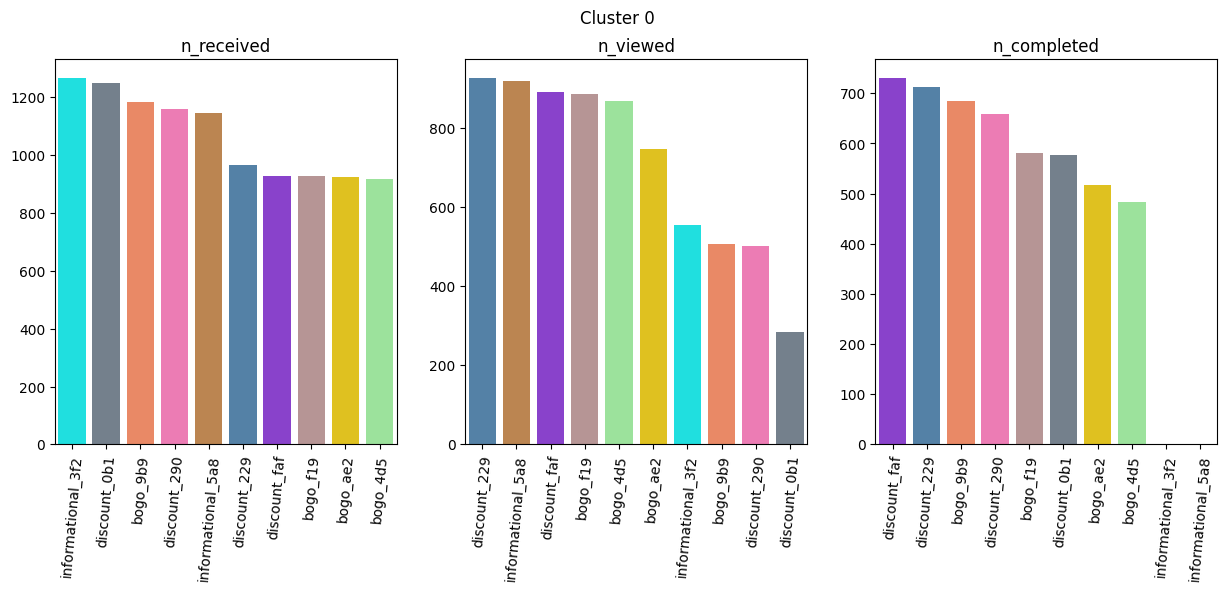

In [116]:
plot_ratios(offers_c1, "n_received", "n_viewed", "n_completed", 0)

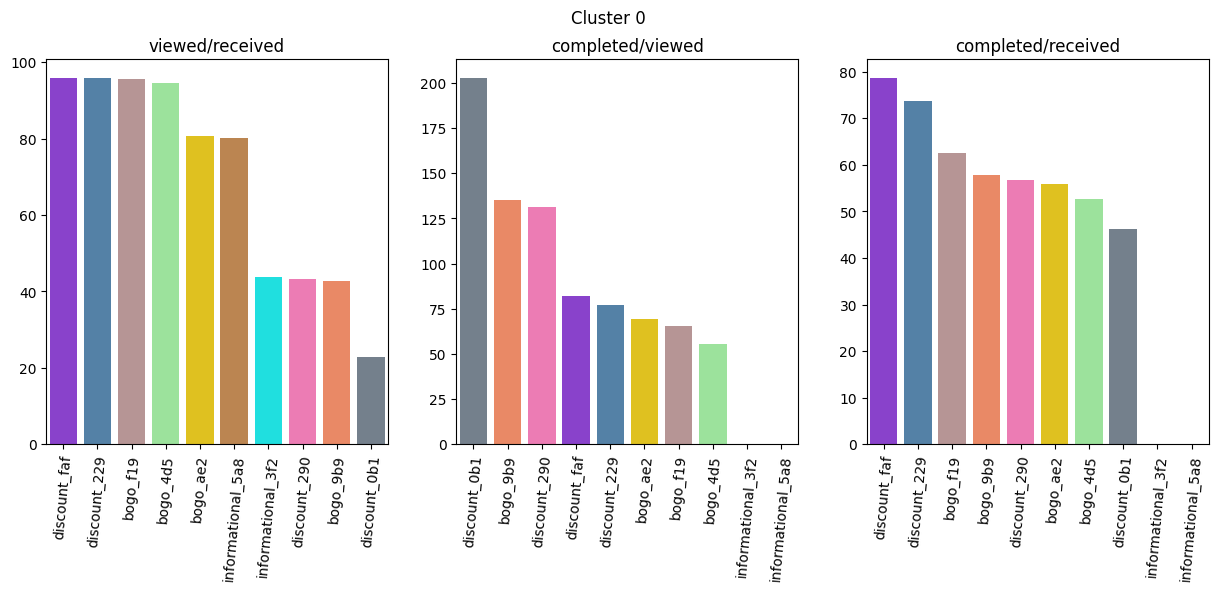

In [117]:
plot_ratios(offers_c1, "viewed/received", "completed/viewed", "completed/received", 0)

**For cluster 0 (Lost or Churned Customers):**

* Considering higher viewing of the offers received: ***discount_faf***, ***discount_229***, ***bogo_f19*** and ***bogo_4d5*** are the best options to send to this group
* ***discount_0b1***, ***bogo_9b9*** and ***discount_290*** have the highest completion to viewing ratio and they are also completed without being viewed. These are the same offers which are less viewed. Therefore these offers can be applied to customers without the need to send them to customers
* At a cut-off of 50% of completed to received offers, only ***bogo_0b1*** will not make it since it has a lower % ratio. Recommendation: don't focus on this offer.
* To get more than 60% conversion from receiving to completion focus on this offers: ***discount_faf***, ***discount_229*** and ***bogo_f19*** however to get the highest conversion focus on ***discount_faf***
* **Overall Recommendation**: For a higher return focus on this three offers in this group - ***discount_faf***, ***discount_229*** and ***bogo_f19***

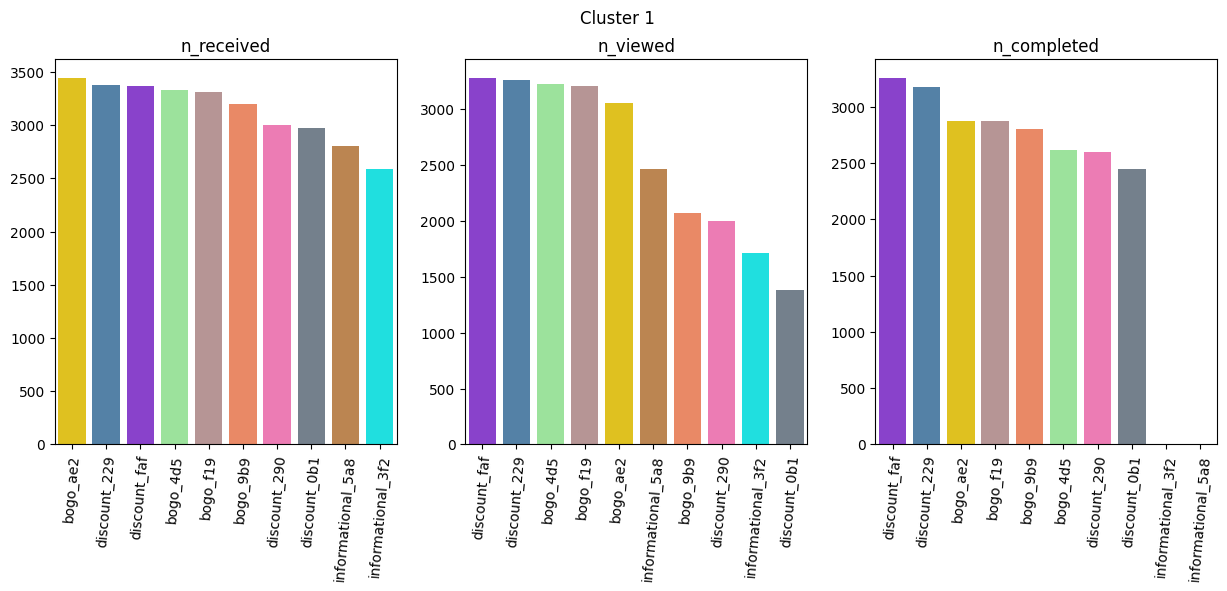

In [118]:
plot_ratios(offers_c2, "n_received", "n_viewed", "n_completed", 1)

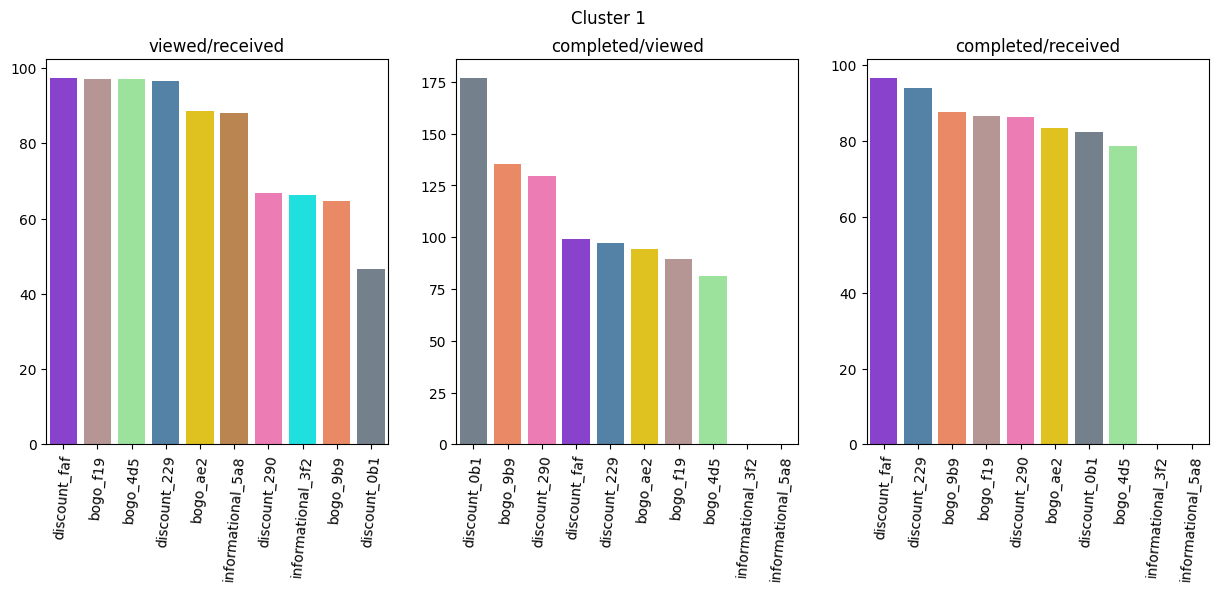

In [119]:
plot_ratios(offers_c2, "viewed/received", "completed/viewed", "completed/received", 1)

**For cluster 1 (Loyal Customers):**

* Considering higher viewing of the offers received: ***discount_faf***, ***discount_229***, ***bogo_f19*** and ***bogo_4d5*** are the best options to send to this group
* ***discount_0b1***, ***bogo_9b9*** and ***discount_290*** have the highest completion to viewing ratio and they are also completed without being viewed. These are the same offers which are less viewed. Therefore these offers can be applied to customers without the need to send them to customers
* At a cut-off of 80% of completed to received offers, only ***bogo_4d5*** will not make it since it has a lower than 80% ratio.
* To get more than 80% conversion from receiving to completion focus on other offers besides ***bogo_4d5*** and ***informational offers*** however to get the highest conversions focus on ***discount_faf*** and ***discount_229***
* **Overall Recommendation**: Since these are loyal customers, sending all thes offers will bring return or higher conversion.

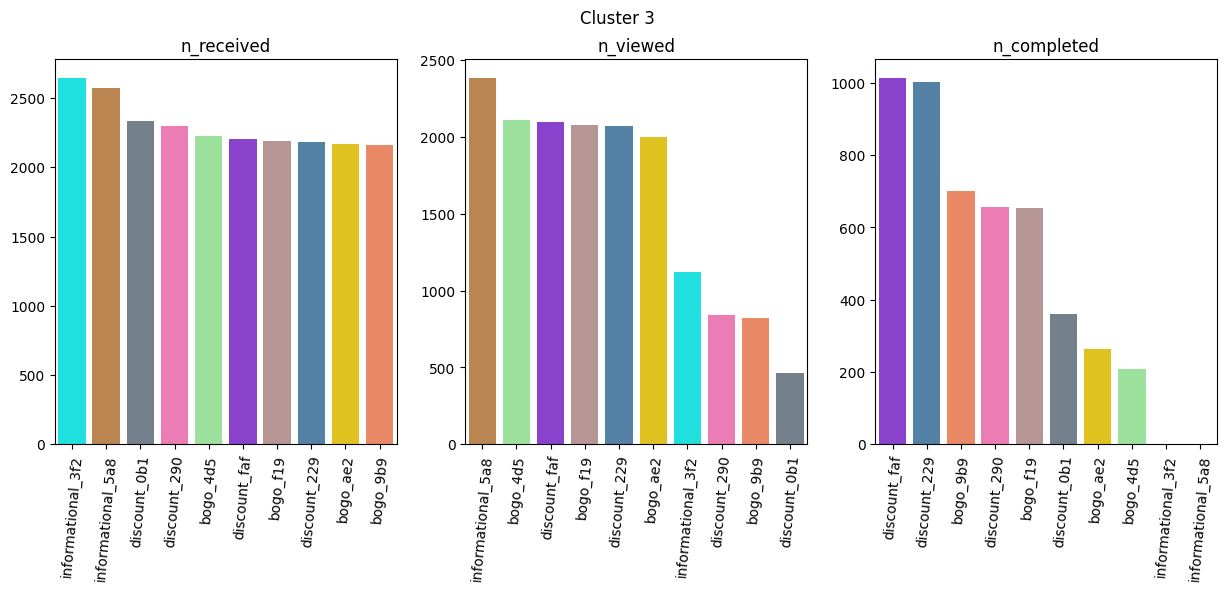

In [120]:
plot_ratios(offers_c3, "n_received", "n_viewed", "n_completed", 3)

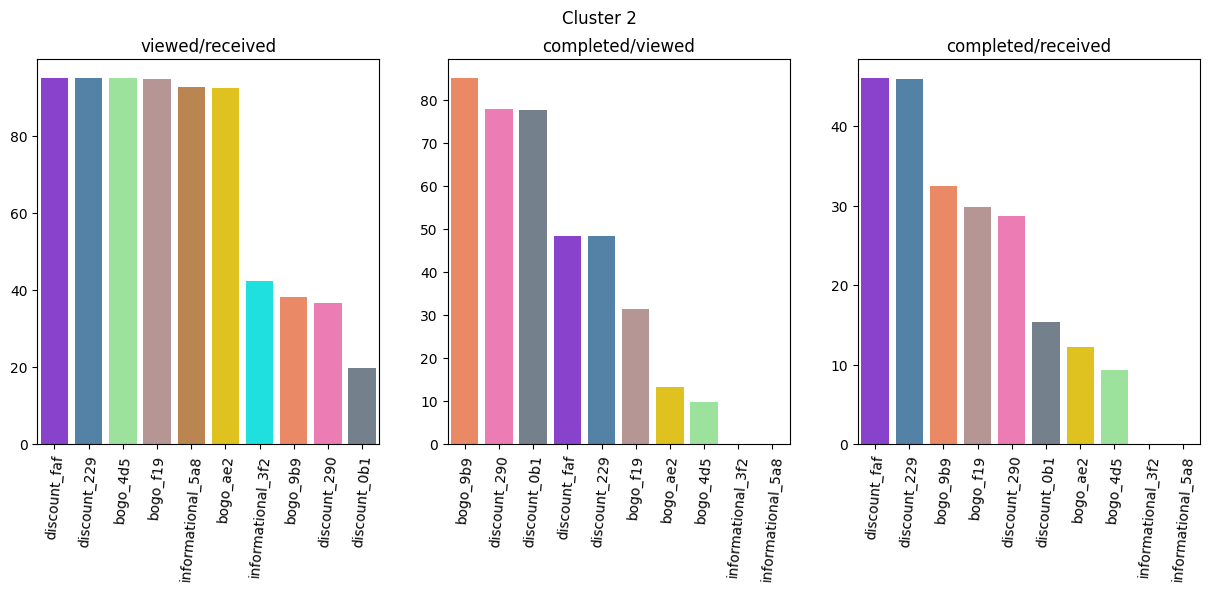

In [121]:
plot_ratios(offers_c3, "viewed/received", "completed/viewed", "completed/received", 2)

**For cluster 2 (At risk customers):**

* Considering higher viewing of the offers received: ***discount_faf***, ***discount_229***, ***bogo_f19***, ***bogo_4d5***, ***informational_5a8*** and ***bogo_ae2*** are the best options to send to this group
* ***discount_0b1***, ***bogo_9b9*** and ***discount_290*** have the highest completion to viewing ratio and no offers were completed without being viewed first. These are the same offers which are less viewed. Therefore these offers can be applied to customers without the need to send them to customers.
* All ratio for completed to received offers are below 50% however ***discount_faf*** and ***discount_229*** have highest % ratio.
* To get more than 40% conversion from receiving to completion focus on this offers: ***discount_faf*** and ***discount_229***
* **Overall Recommendation**: For a higher return focus on this two offers in this group - ***discount_faf*** and ***discount_229***. Since in this group, the return will be low, these offers in this group can be stopped or not sent. 

**Overall Offers:**

* In all clusters ***discount_faf*** and ***discount_229*** are the best two offers which will offer best outcomes. 
* In addition for higher viewing of the offers received ***bogo_f19***, ***bogo_4d5***. 
* Therefore the channels of sending offers should be all four: ***['web', 'email', 'mobile', 'social']***
* ***bogo_ob1*** has the highest dificulty and duration and lowest channels for sending offers. It's completion to receiving ratio is low however it's completion after viewing is high.